In [1]:
import numpy as np
import strax
import straxen
import wfsim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from multihist import Histdd, Hist1d
from scipy import stats
from scipy.interpolate import interp1d
import json

In [2]:
st = straxen.contexts.xenonnt_simulation(output_folder='.')

In [3]:
def instruction_for_fun(c):
    import nestpy
    
    half_life=156.94e-9 #s
    decay_energy=[32.2,9.4] #keV
    
    n = c['nevents'] = c['event_rate']*c['chunk_size']*c['nchunk']
    c['total_time'] = c['chunk_size']*c['nchunk']
    
    instructions = np.zeros(4*n, dtype = wfsim.instruction_dtype)
    instructions['event_number'] = np.digitize(instructions['time'],
                                                  1e9*np.arange(c['nchunk'])*c['chunk_size'])-1 #binning event time to chunks
    
    instructions['type'] = np.tile([1,2],2*n)
    instructions['recoil'] = [7]*4*n
    
    r = np.sqrt(np.random.uniform(0, 60.1**2, n)) 
    t = np.random.uniform(-np.pi, np.pi, n)
    instructions['x'] = np.repeat(r * np.cos(t), 4)
    instructions['y'] = np.repeat(r * np.sin(t), 4)
    instructions['z'] = np.repeat(np.random.uniform(-100, 0, n), 4)
    
    first_s1_time = np.random.uniform(0,c['total_time'],n)
    second_s1_time = first_s1_time + np.random.exponential(half_life/np.log(2),len(first_s1_time))
    
    instructions['time'] = np.repeat(list(zip(first_s1_time,second_s1_time)),2)*1e9
    
    nc = nestpy.nestpy.NESTcalc(nestpy.nestpy.VDetector())
    A=131.293
    Z = 54
    density = 2.862 #g/cm^3
    drift_field = 18.3 #V/cm
    interaction = nestpy.INTERACTION_TYPE(7)
    
    energy = np.tile(decay_energy,n)
    quanta = []
    for en in energy:
        y = nc.GetYields(interaction,en,density,drift_field,A,Z,(1,1)) #?what is this (1,1)
        
        quanta.append(nc.GetQuanta(y,density).photons)
        quanta.append(nc.GetQuanta(y,density).electrons)
    
    instructions['amp'] = quanta
    
    return instructions

In [4]:
wfsim.strax_interface.rand_instructions = instruction_for_fun
st.set_config({'fax_config': 'fax_config_nt_design.json'})

In [5]:
st.set_config(
    dict(fax_config_override=dict(s2_luminescence_model='simple',
                                  enable_noise=False,
                                  enable_pmt_afterpulses=False,
                                  enable_electron_afterpulses=False),
         elife_conf=('elife_constant', 1000000.0, True),
        )
)
st.set_config(dict(nchunk = 2, chunk_size = 20, event_rate = 10))

In [6]:
truth = st.get_array('1','truth')
st.make('1','records')
pks = st.get_array('1','peaks')
events = st.get_array('1','event_info')

Removing old incomplete data in ./1-raw_records-c5f7herpye
Removing old incomplete data in ./1-truth-c5f7herpye
Removing old incomplete data in ./1-raw_records_he-c5f7herpye
Removing old incomplete data in ./1-raw_records_aqmon-c5f7herpye


Simulating Raw Records:  54%|█████▍    | 398/735 [01:01<00:49,  6.76it/s]

RawRecordsFromFaxNT with object id: 140638927858128 waits for chunk 1


Simulating Raw Records: 100%|██████████| 735/735 [01:52<00:00,  6.51it/s]


Source finished!


Loading peaks: |          | 0.00 % [00:00<?]

Loading event_info: |          | 0.00 % [00:00<?]

The CorrectedArea plugin needs to be tuned (change config I guess) in order to use wfsim run_ids. 

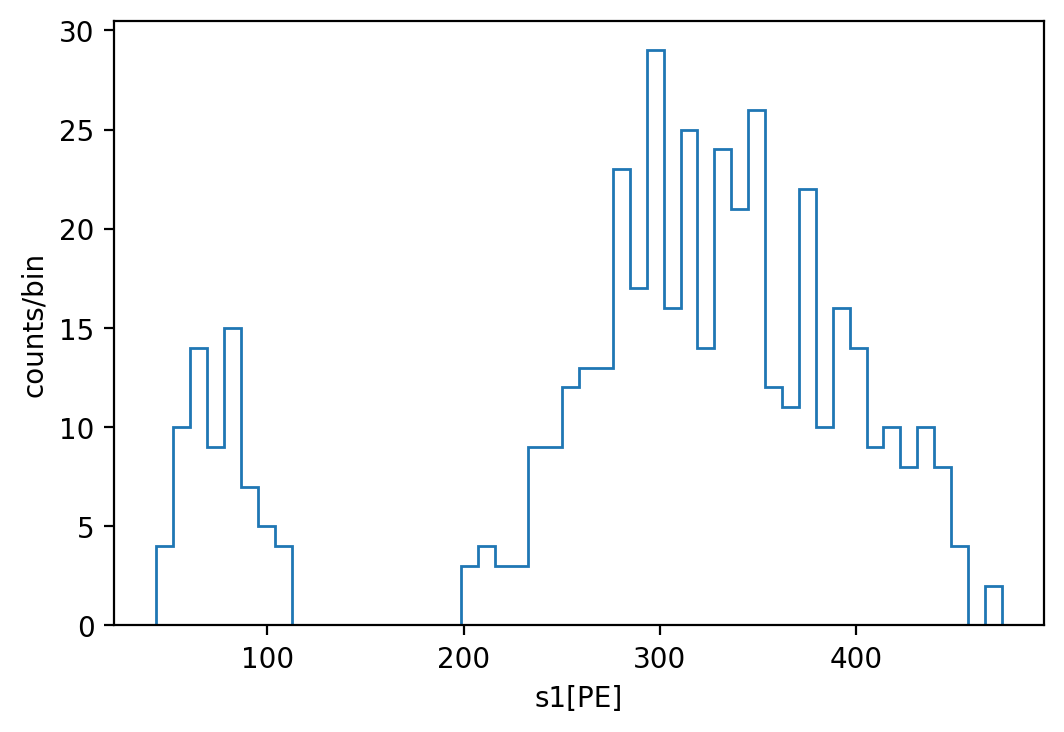

In [10]:
plt.figure(dpi=200)
plt.hist(pks['area'][pks['type']==1],bins=50,histtype='step')
plt.xlabel('s1[PE]')
plt.ylabel('counts/bin')
plt.show()

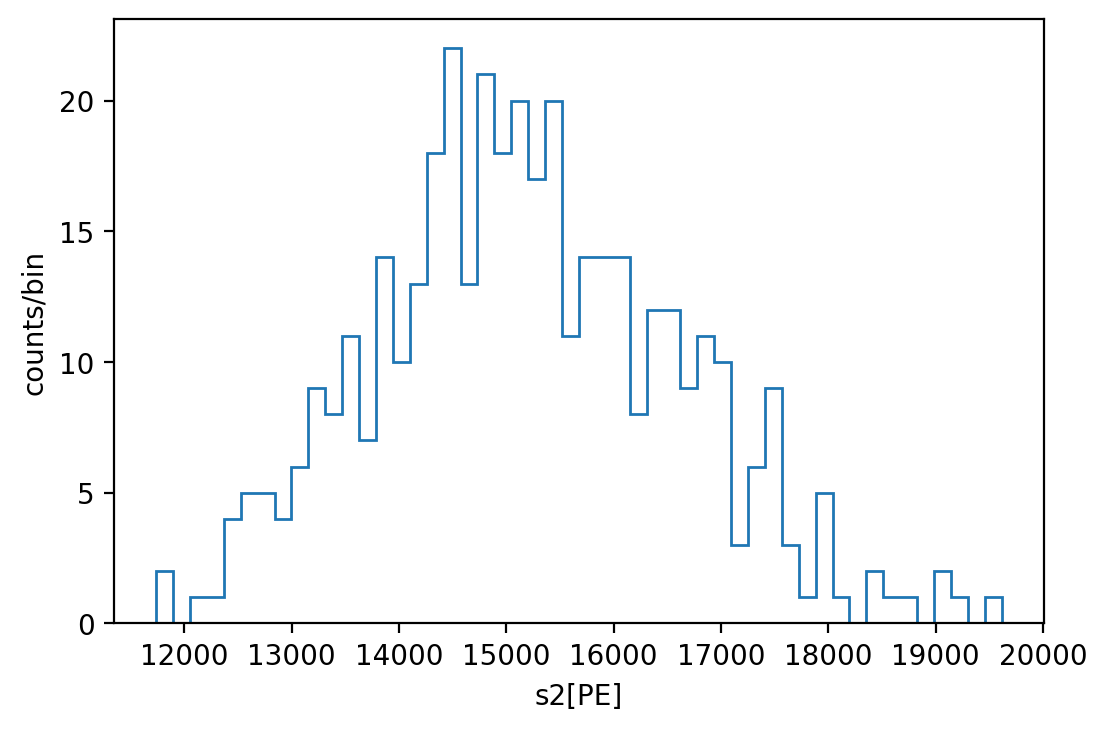

In [11]:
plt.figure(dpi=200)
plt.hist(pks['area'][pks['type']==2],bins=50,histtype='step')
plt.xlabel('s2[PE]')
plt.ylabel('counts/bin')
plt.show()

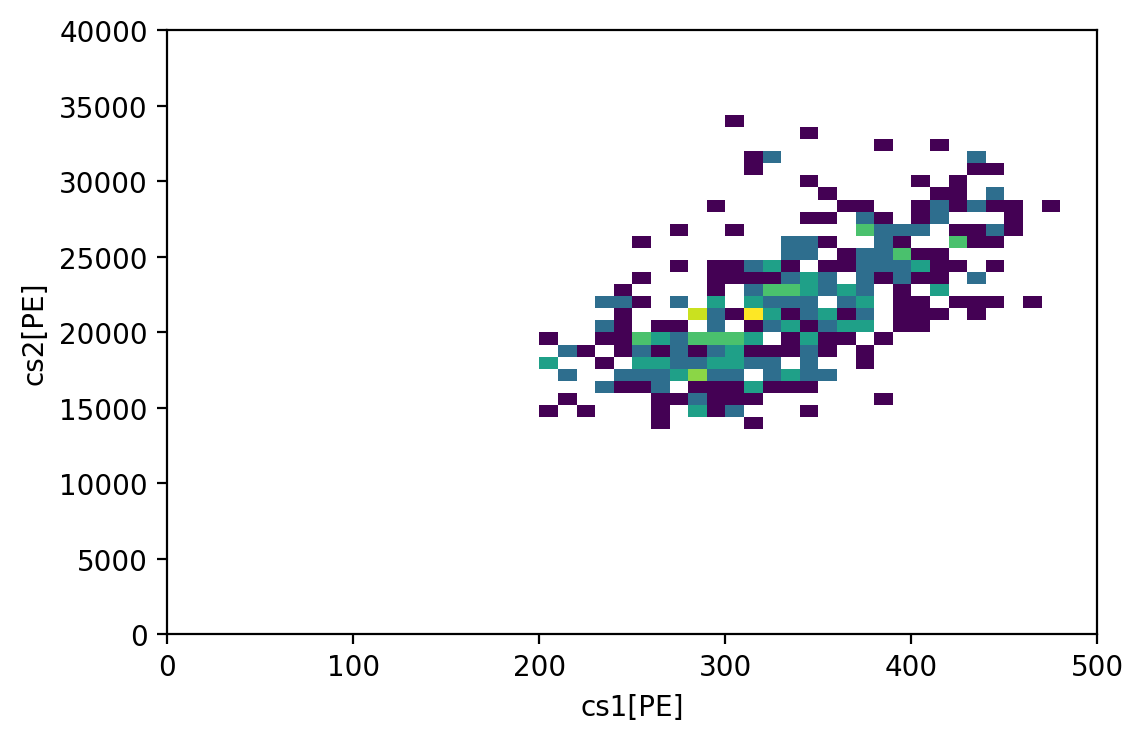

In [12]:
plt.figure(dpi=200)
plt.hist2d(events['cs1'],events['cs2'],bins=(50, 50),range=((0, 500),(0, 40000)),norm=LogNorm())
plt.xlabel('cs1[PE]')
plt.ylabel('cs2[PE]')
plt.show()